In [1]:
!nvidia-smi
#using a Tesla K80 for reproducibility

Tue Jun  2 19:33:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip install backpack-for-pytorch

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True) 

import sys
sys.path.append('/content/gdrive/My Drive/PhD/')

Mounted at /content/gdrive/


In [4]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim, autograd
from torch.nn import functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
from sklearn.utils import shuffle as skshuffle
from math import *
from backpack import backpack, extend
from backpack.extensions import KFAC, DiagHessian
from sklearn.metrics import roc_auc_score
import scipy
from tqdm import tqdm, trange
import pytest
import matplotlib.pyplot as plt
from DirLPA_utils import * 

print("pytorch version: ", torch.__version__)
print("cuda available: ", torch.cuda.is_available())

s = 127
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)
torch.backends.cudnn.deterministic = True

pytorch version:  1.5.0+cu101
cuda available:  True


# Load data

In [0]:
BATCH_SIZE_TRAIN_CIFAR10 = 128
BATCH_SIZE_TEST_CIFAR10 = 128

Files already downloaded and verified
Files already downloaded and verified


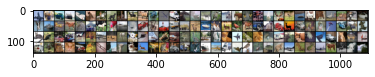

In [6]:
transform_base = [transforms.ToTensor()]

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    ] + transform_base)

transform_test = transforms.Compose(transform_base)
transform_train = transforms.RandomChoice([transform_train, transform_test])

#~/data/cifar10
CIFAR10_trainset = torchvision.datasets.CIFAR10(root='/content/gdrive/My Drive/PhD/data', train=True, download=True, transform=transform_train)
CIFAR10_train_loader = torch.utils.data.DataLoader(CIFAR10_trainset, batch_size=BATCH_SIZE_TRAIN_CIFAR10, shuffle=True, num_workers=2)

#~/data/cifar10
CIFAR10_testset = torchvision.datasets.CIFAR10(root='/content/gdrive/My Drive/PhD/data', train=False, download=True, transform=transform_test)
CIFAR10_test_loader = torch.utils.data.DataLoader(CIFAR10_testset, batch_size=BATCH_SIZE_TEST_CIFAR10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataiter = iter(CIFAR10_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR10/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Files already downloaded and verified
Files already downloaded and verified


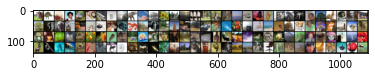

In [7]:
#load in CIFAR100
BATCH_SIZE_TRAIN_CIFAR100 = 128
BATCH_SIZE_TEST_CIFAR100 = 128

#'~/data/cifar100'
CIFAR100_train = torchvision.datasets.CIFAR100(root='/content/gdrive/My Drive/PhD/data', train=True,
                                       download=True, transform=transform_train)
CIFAR100_train_loader = torch.utils.data.DataLoader(CIFAR100_train, batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                         shuffle=False)
#'~/data/cifar100'
CIFAR100_test = torchvision.datasets.CIFAR100(root='/content/gdrive/My Drive/PhD/data', train=False,
                                       download=True, transform=transform_test)
CIFAR100_test_loader = torch.utils.data.DataLoader(CIFAR100_test, batch_size=BATCH_SIZE_TEST_CIFAR100,
                                         shuffle=False)

CIFAR100_classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

dataiter = iter(CIFAR100_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_CIFAR100/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

Using downloaded and verified file: /content/gdrive/My Drive/PhD/data/train_32x32.mat
Using downloaded and verified file: /content/gdrive/My Drive/PhD/data/test_32x32.mat


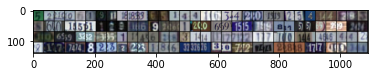

In [8]:
# load SVHN
BATCH_SIZE_TRAIN_SVHN = 128
BATCH_SIZE_TEST_SVHN = 128

#'~/data/SVHN'
train_data_SVHN = torchvision.datasets.SVHN('/content/gdrive/My Drive/PhD/data', split='train',
                             download=True, transform=transform_train)

#'~/data/SVHN'
test_data_SVHN = torchvision.datasets.SVHN('/content/gdrive/My Drive/PhD/data', split='test',
                             download=True, transform=transform_test)

SVHN_train_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TRAIN_SVHN)
SVHN_test_loader = torch.utils.data.DataLoader(test_data_SVHN, batch_size=BATCH_SIZE_TEST_SVHN)

dataiter = iter(SVHN_train_loader)
images, labels = dataiter.next()
nrow = int(BATCH_SIZE_TRAIN_SVHN/4)
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# Train CIFAR100 on ResNet18 (or load weights)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os

In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, num_of_channels=3):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = self.linear(out)
        return out

    def features(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out


def ResNet18(num_of_channels=3, num_classes=10):
    if num_classes <= 2:
        num_classes = 1

    return ResNet(BasicBlock, [2,2,2,2],
                  num_of_channels=num_of_channels,
                  num_classes=num_classes)

def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda_status = torch.cuda.is_available()
CIFAR100_model = ResNet18(num_classes=100).to(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR100_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

In [0]:
# Training
def train(net, epoch, optimizer, trainloader, filename):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    
    print("train loss: ", train_loss)
    print("train accuracy: ", correct/total)
    print("saving model at: {}".format(filename))
    torch.save(net.state_dict(), filename)

In [0]:
def test(net, epoch, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
        print("test loss: ", test_loss)
        print("test accuracy: ", correct/total)

In [0]:
def train_all():
    CIFAR10_path = 'weights/cifar100_resnet18_SGD.pth'
    lr = 0.1
    epoch = 0
    for e in [100, 50, 50]:
        print("current learning rate: ", lr)
        for _ in range(e):
            optimizer = optim.SGD(CIFAR100_model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
            train(CIFAR100_model, epoch, optimizer, CIFAR100_train_loader, CIFAR100_path)
            test(CIFAR100_model, epoch, CIFAR100_test_loader)
            epoch += 1
        lr /= 10

In [0]:
#train_all()

In [17]:
##### if you already have a trained model ##############
#CIFAR10_PATH = 'weights/CIFAR10_pretrained.pt'
CIFAR100_PATH = '/content/gdrive/My Drive/PhD/weights/CIFAR100_pretrained.pt'
CIFAR100_model = ResNet18(num_classes=100).to(device)
print("loading model from: {}".format(CIFAR100_PATH))
CIFAR100_model.load_state_dict(torch.load(CIFAR100_PATH))#, map_location=torch.device('cpu')))
#test the model
test(CIFAR100_model, 0, CIFAR100_test_loader)

loading model from: /content/gdrive/My Drive/PhD/weights/CIFAR100_pretrained.pt
test loss:  71.76387017965317
test accuracy:  0.7675


# prepare Gaussians (Diag and KFAC)

In [0]:
M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D = Diag_second_order(model=CIFAR100_model,
                                                               train_loader=CIFAR100_train_loader,
                                                               prec0 = 75,
                                                               device=device)

n: 512 inputs to linear layer with m: 100 classes
Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 6

In [18]:
M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K = KFLP_second_order(model=CIFAR100_model,
                                                               train_loader=CIFAR100_train_loader,
                                                               batch_size=BATCH_SIZE_TRAIN_CIFAR100,
                                                               var0 = 2,
                                                               device=device)

Batch: 0/391
Batch: 1/391
Batch: 2/391
Batch: 3/391
Batch: 4/391
Batch: 5/391
Batch: 6/391
Batch: 7/391
Batch: 8/391
Batch: 9/391
Batch: 10/391
Batch: 11/391
Batch: 12/391
Batch: 13/391
Batch: 14/391
Batch: 15/391
Batch: 16/391
Batch: 17/391
Batch: 18/391
Batch: 19/391
Batch: 20/391
Batch: 21/391
Batch: 22/391
Batch: 23/391
Batch: 24/391
Batch: 25/391
Batch: 26/391
Batch: 27/391
Batch: 28/391
Batch: 29/391
Batch: 30/391
Batch: 31/391
Batch: 32/391
Batch: 33/391
Batch: 34/391
Batch: 35/391
Batch: 36/391
Batch: 37/391
Batch: 38/391
Batch: 39/391
Batch: 40/391
Batch: 41/391
Batch: 42/391
Batch: 43/391
Batch: 44/391
Batch: 45/391
Batch: 46/391
Batch: 47/391
Batch: 48/391
Batch: 49/391
Batch: 50/391
Batch: 51/391
Batch: 52/391
Batch: 53/391
Batch: 54/391
Batch: 55/391
Batch: 56/391
Batch: 57/391
Batch: 58/391
Batch: 59/391
Batch: 60/391
Batch: 61/391
Batch: 62/391
Batch: 63/391
Batch: 64/391
Batch: 65/391
Batch: 66/391
Batch: 67/391
Batch: 68/391
Batch: 69/391
Batch: 70/391
Batch: 71/391
Ba

In [0]:
targets_CIFAR100 = CIFAR100_test.targets
targets_CIFAR10 = CIFAR10_testset.targets
targets_SVHN = []
for x,y in SVHN_test_loader:
    targets_SVHN.append(y)
targets_SVHN = torch.cat(targets_SVHN).numpy()

In [0]:
num_samples = 100

# MAP estimate

In [0]:
CIFAR100_test_in_MAP = predict_MAP(CIFAR100_model, CIFAR100_test_loader, cuda=cuda_status).cpu().numpy()
CIFAR100_test_out_CIFAR10_MAP = predict_MAP(CIFAR100_model, CIFAR10_test_loader, cuda=cuda_status).cpu().numpy()
CIFAR100_test_out_SVHN_MAP = predict_MAP(CIFAR100_model, SVHN_test_loader, cuda=cuda_status).cpu().numpy()

In [0]:
acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP = get_in_dist_values(CIFAR100_test_in_MAP, targets_CIFAR100)
acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_CIFAR10_MAP, targets_CIFAR10)
acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP = get_out_dist_values(CIFAR100_test_in_MAP, CIFAR100_test_out_SVHN_MAP, targets_SVHN)

In [0]:
print_in_dist_values(acc_in_MAP, prob_correct_in_MAP, ent_in_MAP, MMC_in_MAP, 'CIFAR100', 'MAP')
print_out_dist_values(acc_out_CIFAR10_MAP, prob_correct_out_CIFAR10_MAP, ent_out_CIFAR10, MMC_out_CIFAR10_MAP, auroc_out_CIFAR10_MAP, 'CIFAR10', 'MAP')
print_out_dist_values(acc_out_SVHN_MAP, prob_correct_out_SVHN_MAP, ent_out_SVHN, MMC_out_SVHN_MAP, auroc_out_SVHN_MAP, 'SVHN', 'MAP')

[In, MAP, CIFAR100] Accuracy: 0.767; average entropy: 0.777;     MMC: 0.812; Prob @ correct: 0.010
[Out-MAP, KFAC, CIFAR10] Accuracy: 0.005; Average entropy: 1.953;    MMC: 0.533; AUROC: 0.786; Prob @ correct: 0.010
[Out-MAP, KFAC, SVHN] Accuracy: 0.003; Average entropy: 2.006;    MMC: 0.535; AUROC: 0.788; Prob @ correct: 0.010


In [0]:
#MAP estimate
#seeds are 123,124,125,126,127
acc_in = [0.767, 0.767, 0.767, 0.767, 0.767]
mmc_in = [0.812, 0.812, 0.812, 0.812, 0.812]
mmc_out_CIFAR10 = [0.533, 0.533, 0.533, 0.533, 0.533]
mmc_out_SVHN = [0.535, 0.535, 0.535, 0.535, 0.535]

auroc_out_CIFAR10 = [0.786, 0.786, 0.786, 0.786, 0.786]
auroc_out_SVHN = [0.788, 0.788, 0.788, 0.788, 0.788]

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

accuracy: 0.767 with std 0.000
MMC in: 0.812 with std 0.000
MMC out CIFAR10: 0.533 with std 0.000
MMC out SVHN: 0.535 with std 0.000
AUROC out CIFAR10: 0.786 with std 0.000
AUROC out SVHN: 0.788 with std 0.000


# Diagonal estimate

In [0]:
CIFAR100_test_in_D = predict_diagonal_sampling(CIFAR100_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_D = predict_diagonal_sampling(CIFAR100_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_D = predict_diagonal_sampling(CIFAR100_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for sampling with 100 samples: 1.3858613967895508
time used for sampling with 100 samples: 1.363412618637085
time used for sampling with 100 samples: 3.5238916873931885


In [0]:
acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D = get_in_dist_values(CIFAR100_test_in_D, targets_CIFAR100)
acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10_D, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_CIFAR10_D, targets_CIFAR10)
acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D = get_out_dist_values(CIFAR100_test_in_D, CIFAR100_test_out_SVHN_D, targets_SVHN)

In [0]:
print_in_dist_values(acc_in_D, prob_correct_in_D, ent_in_D, MMC_in_D, 'CIFAR100', 'Diag')
print_out_dist_values(acc_out_CIFAR10_D, prob_correct_out_CIFAR10_D, ent_out_CIFAR10, MMC_out_CIFAR10_D, auroc_out_CIFAR10_D, 'CIFAR10', 'Diag')
print_out_dist_values(acc_out_SVHN_D, prob_correct_out_SVHN_D, ent_out_SVHN_D, MMC_out_SVHN_D, auroc_out_SVHN_D, 'SVHN', 'Diag')

[In, Diag, CIFAR100] Accuracy: 0.766; average entropy: 0.996;     MMC: 0.762; Prob @ correct: 0.010
[Out-Diag, KFAC, CIFAR10] Accuracy: 0.006; Average entropy: 1.953;    MMC: 0.467; AUROC: 0.788; Prob @ correct: 0.010
[Out-Diag, KFAC, SVHN] Accuracy: 0.003; Average entropy: 2.328;    MMC: 0.462; AUROC: 0.795; Prob @ correct: 0.010


In [0]:
#Diag Sampling with 100 samples
#seeds are 123,124,125,126,127
time_lpb_in = [1.6586072444915771, 1.627324104309082, 1.7564799785614014, 1.6644256114959717]
time_lpb_out_CIFAR10 = [1.5935437679290771, 1.6351218223571777, 1.6811020374298096, 1.6301469802856445]
time_lpb_out_SVHN = [4.099160194396973, 4.207411527633667, 4.283984899520874, 4.175244331359863]

acc_in = [0.766, 0.776, 0.768, 0.767, 0.766]
mmc_in = [0.762, 0.762, 0.762, 0.762, 0.762]
mmc_out_CIFAR10 = [0.467, 0.468, 0.467, 0.467, 0.467]
mmc_out_SVHN = [0.462, 0.462, 0.462, 0.462, 0.462]

auroc_out_CIFAR10 = [0.788, 0.788, 0.788, 0.788, 0.788]
auroc_out_SVHN = [0.795, 0.794, 0.795, 0.795, 0.795]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 1.677 with std 0.048
Sampling Bridge time out CIFAR100: 1.635 with std 0.031
Sampling Bridge time out SVHN: 4.191 with std 0.066
accuracy: 0.769 with std 0.004
MMC in: 0.762 with std 0.000
MMC out CIFAR10: 0.467 with std 0.000
MMC out SVHN: 0.462 with std 0.000
AUROC out CIFAR10: 0.788 with std 0.000
AUROC out SVHN: 0.795 with std 0.000


In [0]:
#Diag Sampling with 1000 samples
#seeds are 123,124,125,126,127
time_lpb_in = [24.47496271133423, 24.330116987228394, 24.31259536743164, 24.778072357177734, 24.60563015937805]
time_lpb_out_CIFAR10 = [24.486239671707153, 24.288117170333862, 24.30678367614746, 24.703003406524658, 24.546699285507202]
time_lpb_out_SVHN = [63.5619101524353, 63.03484845161438, 62.94664406776428, 63.907883644104004, 63.63693714141846]

acc_in = [0.768, 0.767, 0.767, 0.768, 767]
mmc_in = [0.762, 0.762, 0.762, 0.762, 0.762]
mmc_out_CIFAR10 = [0.467, 0.467, 0.467, 0.467, 0.467]
mmc_out_SVHN = [0.461, 0.461, 0.461, 0.461, 0.461]

auroc_out_CIFAR10 = [0.788, 0.788, 0.788, 0.788, 0.788]
auroc_out_SVHN = [0.795, 0.795, 0.795, 0.795, 0.795]

print("Sampling Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Sampling Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Sampling Bridge time out SVHN: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Sampling Bridge time in: 24.500 with std 0.175
Sampling Bridge time out CIFAR100: 24.466 with std 0.155
Sampling Bridge time out SVHN: 63.418 with std 0.368
accuracy: 154.014 with std 306.493
MMC in: 0.762 with std 0.000
MMC out CIFAR10: 0.467 with std 0.000
MMC out SVHN: 0.461 with std 0.000
AUROC out CIFAR10: 0.788 with std 0.000
AUROC out SVHN: 0.795 with std 0.000


# KFAC estimate

In [0]:
CIFAR100_test_in_K = predict_KFAC_sampling(CIFAR100_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_K = predict_KFAC_sampling(CIFAR100_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_K = predict_KFAC_sampling(CIFAR100_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, n_samples=num_samples, cuda=cuda_status, timing=True).cpu().numpy()

time used for sampling with 100 samples: 1.3819525241851807
time used for sampling with 100 samples: 1.4230587482452393
time used for sampling with 100 samples: 3.488450050354004


In [0]:
acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K = get_in_dist_values(CIFAR100_test_in_K, targets_CIFAR100)
acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10_K, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K = get_out_dist_values(CIFAR100_test_in_K, CIFAR100_test_out_CIFAR10_K, targets_CIFAR10)
acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K = get_out_dist_values(CIFAR100_test_in_K, CIFAR100_test_out_SVHN_K, targets_SVHN)

In [0]:
print_in_dist_values(acc_in_K, prob_correct_in_K, ent_in_K, MMC_in_K, 'CIFAR100', 'KFAC')
print_out_dist_values(acc_out_CIFAR10_K, prob_correct_out_CIFAR10_K, ent_out_CIFAR10, MMC_out_CIFAR10_K, auroc_out_CIFAR10_K, 'CIFAR10', 'KFAC')
print_out_dist_values(acc_out_SVHN_K, prob_correct_out_SVHN_K, ent_out_SVHN_K, MMC_out_SVHN_K, auroc_out_SVHN_K, 'SVHN', 'KFAC')

[In, KFAC, CIFAR100] Accuracy: 0.764; average entropy: 2.806;     MMC: 0.406; Prob @ correct: 0.010
[Out-KFAC, KFAC, CIFAR10] Accuracy: 0.005; Average entropy: 1.953;    MMC: 0.216; AUROC: 0.785; Prob @ correct: 0.010
[Out-KFAC, KFAC, SVHN] Accuracy: 0.003; Average entropy: 3.684;    MMC: 0.182; AUROC: 0.836; Prob @ correct: 0.010


In [0]:
#KFAC approximation of the Hessian with 100 samples
#seeds are 123,124,125,126,127
time_lpb_in = [1.5946142673492432, 1.5896697044372559, 1.6409170627593994, 1.6308801174163818]
time_lpb_out_CIFAR10 = [1.5854673385620117, 1.6363048553466797, 1.6802825927734375, 1.5992817878723145]
time_lpb_out_SVHN = [4.145058870315552, 4.171476125717163, 4.284167528152466, 4.190131187438965]


acc_in = [0.762, 0.763, 0.763, 0.763, 0.764]
mmc_in = [0.406, 0.404, 0.404, 0.406, 0.406]
mmc_out_CIFAR10 = [0.216, 0.216, 0.216, 0.217, 0.216]
mmc_out_SVHN = [0.183, 0.181, 0.181, 0.181, 0.182]

auroc_out_CIFAR10 = [0.785, 0.785, 0.785, 0.785, 0.785]
auroc_out_SVHN = [0.835, 0.837, 0.837, 0.837, 0.836]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 1.614 with std 0.022
Laplace Bridge time out CIFAR100: 1.625 with std 0.037
Laplace Bridge time out notmnist: 4.198 with std 0.052
accuracy: 0.763 with std 0.001
MMC in: 0.405 with std 0.001
MMC out CIFAR100: 0.216 with std 0.000
MMC out SVHN: 0.182 with std 0.001
AUROC out CIFAR100: 0.785 with std 0.000
AUROC out SVHN: 0.836 with std 0.001


In [0]:
#KFAC approximation of the Hessian with 1000 samples
#seeds are 123,124,125,126,127
time_lpb_in = [24.671594858169556, 24.539386510849, 24.526949644088745, 24.772101879119873, 24.738290309906006]
time_lpb_out_CIFAR10 = [24.63983678817749, 24.532172679901123, 24.533291816711426, 24.747743606567383, 24.677521467208862]
time_lpb_out_SVHN = [63.71370983123779, 63.57585334777832, 63.600560903549194, 64.22876906394958, 64.00463771820068]


acc_in = [0.767, 0.768, 0.768, 0.768, 0.768]
mmc_in = [0.404, 0.405, 0.405, 0.404, 0.404]
mmc_out_CIFAR10 = [0.213, 0.213, 0.213, 0.213, 0.213]
mmc_out_SVHN = [0.181, 0.179, 0.180, 0.180, 0.180]

auroc_out_CIFAR10 = [0.788, 0.788, 0.788, 0.788, 0.788]
auroc_out_SVHN = [0.836, 0.840, 0.838, 0.838, 0.838]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR100: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 24.650 with std 0.101
Laplace Bridge time out CIFAR100: 24.626 with std 0.084
Laplace Bridge time out notmnist: 63.825 with std 0.253
accuracy: 0.768 with std 0.000
MMC in: 0.404 with std 0.000
MMC out CIFAR100: 0.213 with std 0.000
MMC out SVHN: 0.180 with std 0.001
AUROC out CIFAR100: 0.788 with std 0.000
AUROC out SVHN: 0.838 with std 0.001


# Laplace Bridge estimate

In [0]:
CIFAR100_test_in_LB = predict_LB(CIFAR100_model, CIFAR100_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_LB = predict_LB(CIFAR100_model, CIFAR10_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_LB = predict_LB(CIFAR100_model, SVHN_test_loader, M_W_post_D, M_b_post_D, C_W_post_D, C_b_post_D, cuda=cuda_status, timing=True).cpu().numpy()

total time used for transform: 0.03602
total time used for transform: 0.02676
total time used for transform: 0.06514


In [0]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR100_test_in_LBn = CIFAR100_test_in_LB/CIFAR100_test_in_LB.sum(1).reshape(-1,1)
CIFAR100_test_out_CIFAR10_LBn = CIFAR100_test_out_CIFAR10_LB/CIFAR100_test_out_CIFAR10_LB.sum(1).reshape(-1,1)
CIFAR100_test_out_SVHN_LBn = CIFAR100_test_out_SVHN_LB/CIFAR100_test_out_SVHN_LB.sum(1).reshape(-1,1)

In [0]:
acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB = get_in_dist_values(CIFAR100_test_in_LBn, targets_CIFAR100)
acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB = get_out_dist_values(CIFAR100_test_in_LBn, CIFAR100_test_out_CIFAR10_LBn, targets_CIFAR10)
acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB = get_out_dist_values(CIFAR100_test_in_LBn, CIFAR100_test_out_SVHN_LBn, targets_SVHN)

In [0]:
print_in_dist_values(acc_in_LB, prob_correct_in_LB, ent_in_LB, MMC_in_LB, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB, prob_correct_out_CIFAR10_LB, ent_out_CIFAR10_LB, MMC_out_CIFAR10_LB, auroc_out_CIFAR10_LB, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB, prob_correct_out_SVHN_LB, ent_out_SVHN_LB, MMC_out_SVHN_LB, auroc_out_SVHN_LB, 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR100] Accuracy: 0.767; average entropy: 2.134;     MMC: 0.590; Prob @ correct: 0.010
[Out-Laplace Bridge, KFAC, CIFAR10] Accuracy: 0.005; Average entropy: 3.900;    MMC: 0.206; AUROC: 0.791; Prob @ correct: 0.010
[Out-Laplace Bridge, KFAC, SVHN] Accuracy: 0.003; Average entropy: 4.083;    MMC: 0.171; AUROC: 0.815; Prob @ correct: 0.010


In [0]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.03903, 0.02828, 0.02678, 0.02801, 0.02545]
time_lpb_out_CIFAR10 = [0.02931, 0.02780, 0.02469, 0.02808, 0.02635]
time_lpb_out_SVHN = [0.07514, 0.06998, 0.06393, 0.07197, 0.06615]

acc_in = [0.767, 0.767, 0.767, 0.767, 0.767]
mmc_in = [0.590, 0.590, 0.590, 0.590, 0.590]
mmc_out_CIFAR10 = [0.206, 0.206, 0.206, 0.206, 0.206]
mmc_out_SVHN = [0.170, 0.170, 0.170, 0.170, 0.170]

auroc_out_CIFAR10 = [0.791, 0.791, 0.791, 0.791, 0.791]
auroc_out_SVHN = [0.815, 0.815, 0.815, 0.815, 0.815]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.030 with std 0.005
Laplace Bridge time out CIFAR10: 0.027 with std 0.002
Laplace Bridge time out notmnist: 0.069 with std 0.004
accuracy: 0.767 with std 0.000
MMC in: 0.590 with std 0.000
MMC out CIFAR10: 0.206 with std 0.000
MMC out SVHN: 0.170 with std 0.000
AUROC out CIFAR10: 0.791 with std 0.000
AUROC out SVHN: 0.815 with std 0.000


# Laplace Bridge KFAC

In [20]:
CIFAR100_test_in_LB_KFAC = predict_LB_KFAC(CIFAR100_model, CIFAR100_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, verbose=False, timing=True).cpu().numpy()
CIFAR100_test_out_CIFAR10_LB_KFAC = predict_LB_KFAC(CIFAR100_model, CIFAR10_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()
CIFAR100_test_out_SVHN_LB_KFAC = predict_LB_KFAC(CIFAR100_model, SVHN_test_loader, M_W_post_K, M_b_post_K, U_post_K, V_post_K, B_post_K, cuda=cuda_status, timing=True).cpu().numpy()

total time used for transform: 0.01992
total time used for transform: 0.01904
total time used for transform: 0.04921


In [0]:
#normalize to get the MAP estimate (which is the mode) of the Dirichlet
CIFAR100_test_in_LB_KFACn = CIFAR100_test_in_LB_KFAC/CIFAR100_test_in_LB_KFAC.sum(1).reshape(-1,1)
CIFAR100_test_out_CIFAR10_LB_KFACn = CIFAR100_test_out_CIFAR10_LB_KFAC/CIFAR100_test_out_CIFAR10_LB_KFAC.sum(1).reshape(-1,1)
CIFAR100_test_out_SVHN_LB_KFACn = CIFAR100_test_out_SVHN_LB_KFAC/CIFAR100_test_out_SVHN_LB_KFAC.sum(1).reshape(-1,1)

In [0]:
acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC = get_in_dist_values(CIFAR100_test_in_LB_KFACn, targets_CIFAR100)
acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC = get_out_dist_values(CIFAR100_test_in_LB_KFACn, CIFAR100_test_out_CIFAR10_LB_KFACn, targets_CIFAR10)
acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC = get_out_dist_values(CIFAR100_test_in_LB_KFACn, CIFAR100_test_out_SVHN_LB_KFACn, targets_SVHN)

In [23]:
print_in_dist_values(acc_in_LB_KFAC, prob_correct_in_LB_KFAC, ent_in_LB_KFAC, MMC_in_LB_KFAC, 'CIFAR100', 'Laplace Bridge')
print_out_dist_values(acc_out_CIFAR10_LB_KFAC, prob_correct_out_CIFAR10_LB_KFAC, ent_out_CIFAR10_LB_KFAC, MMC_out_CIFAR10_LB_KFAC, auroc_out_CIFAR10_LB_KFAC, 'CIFAR10', 'Laplace Bridge')
print_out_dist_values(acc_out_SVHN_LB_KFAC, prob_correct_out_SVHN_LB_KFAC, ent_out_SVHN_LB_KFAC, MMC_out_SVHN_LB_KFAC, auroc_out_SVHN_LB_KFAC, 'SVHN', 'Laplace Bridge')

[In, Laplace Bridge, CIFAR100] Accuracy: 0.768; average entropy: 2.118;     MMC: 0.593; Prob @ correct: 0.010
[Out-Laplace Bridge, KFAC, CIFAR10] Accuracy: 0.006; Average entropy: 3.890;    MMC: 0.209; AUROC: 0.791; Prob @ correct: 0.010
[Out-Laplace Bridge, KFAC, SVHN] Accuracy: 0.003; Average entropy: 4.073;    MMC: 0.173; AUROC: 0.815; Prob @ correct: 0.010


In [24]:
#Laplace Bridge
#seeds are 123,124,125,126,127
time_lpb_in = [0.03903, 0.02828, 0.02678, 0.02801, 0.02545]
time_lpb_out_CIFAR10 = [0.02931, 0.02780, 0.02469, 0.02808, 0.02635]
time_lpb_out_SVHN = [0.07514, 0.06998, 0.06393, 0.07197, 0.06615]

acc_in = [0.768, 0.768, 0.767, 0.768, 0.768]
mmc_in = [0.593, 0.593, 0.593, 0.593, 0.593]
mmc_out_CIFAR10 = [0.209, 0.209, 0.209, 0.209, 0.209]
mmc_out_SVHN = [0.174, 0.174, 0.173, 0.173, 0.173]

auroc_out_CIFAR10 = [0.791, 0.791, 0.791, 0.791, 0.791]
auroc_out_SVHN = [0.814, 0.814, 0.815, 0.815, 0.815]


print("Laplace Bridge time in: {:.03f} with std {:.03f}".format(np.mean(time_lpb_in), np.std(time_lpb_in)))
print("Laplace Bridge time out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_CIFAR10), np.std(time_lpb_out_CIFAR10)))
print("Laplace Bridge time out notmnist: {:.03f} with std {:.03f}".format(np.mean(time_lpb_out_SVHN), np.std(time_lpb_out_SVHN)))

print("accuracy: {:.03f} with std {:.03f}".format(np.mean(acc_in), np.std(acc_in)))

print("MMC in: {:.03f} with std {:.03f}".format(np.mean(mmc_in), np.std(mmc_in)))
print("MMC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(mmc_out_CIFAR10), np.std(mmc_out_CIFAR10)))
print("MMC out SVHN: {:.03f} with std {:.03f}".format(np.mean(mmc_out_SVHN), np.std(mmc_out_SVHN)))

print("AUROC out CIFAR10: {:.03f} with std {:.03f}".format(np.mean(auroc_out_CIFAR10), np.std(auroc_out_CIFAR10)))
print("AUROC out SVHN: {:.03f} with std {:.03f}".format(np.mean(auroc_out_SVHN), np.std(auroc_out_SVHN)))

Laplace Bridge time in: 0.030 with std 0.005
Laplace Bridge time out CIFAR10: 0.027 with std 0.002
Laplace Bridge time out notmnist: 0.069 with std 0.004
accuracy: 0.768 with std 0.000
MMC in: 0.593 with std 0.000
MMC out CIFAR10: 0.209 with std 0.000
MMC out SVHN: 0.173 with std 0.000
AUROC out CIFAR10: 0.791 with std 0.000
AUROC out SVHN: 0.815 with std 0.000


# Condition

In [0]:
# check if condition holds

def check_condition(alpha_vecs):
    #note that this is vectorized
    alpha_sum = alpha_vecs.sum(1)
    alpha_max = alpha_vecs.max(1)
    alpha_sum_minus = alpha_sum - alpha_max
    right_side = 0.25 * (np.sqrt(9 * alpha_sum_minus**2 + 10 * alpha_sum_minus + 1) - alpha_sum_minus - 1)
    cases = alpha_max > right_side
    percentage = np.sum(cases)/len(cases)
    return(percentage)

In [0]:
print(np.sum(check_condition(CIFAR100_test_in_LB)))
print(np.sum(check_condition(CIFAR100_test_out_CIFAR10_LB)))
print(np.sum(check_condition(CIFAR100_test_out_SVHN_LB)))

0.6621
0.2147
0.16664105716041794


In [0]:
condition_CIFAR100_in = np.array([0.6621, 0.6621, 0.6623, 0.6621, 0.6619])
condition_CIFAR10_out = np.array([0.2145, 0.2146, 0.2146, 0.2143, 0.2143])
condition_SVHN_out = np.array([0.16606484326982177, 0.1657959434542102, 0.16644898586355256, 0.16621850030731408, 0.1663721573448064])

print("ratio condition fulfilled CIFAR100 in: {:.03f} with std: {}".format(np.mean(condition_CIFAR100_in), np.std(condition_CIFAR100_in)))
print("ratio condition fulfilled CIFAR10 out: {:.03f} with std: {}".format(np.mean(condition_CIFAR10_out), np.std(condition_CIFAR10_out)))
print("ratio condition fulfilled SVHN out: {:.03f} with std: {}".format(np.mean(condition_SVHN_out), np.std(condition_SVHN_out)))

ratio condition fulfilled CIFAR100 in: 0.662 with std: 0.00012649110640672122
ratio condition fulfilled CIFAR10 out: 0.214 with std: 0.00013564659966251497
ratio condition fulfilled SVHN out: 0.166 with std: 0.0002330324352812433
